In [1]:
from alphatools.research import run_pipeline, make_factor_plot
from alphatools.expression import ExpressionAlpha
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline

In [2]:
universe = AverageDollarVolume(window_length=120).top(500)

In [3]:
expressions = {
    8:  '(-1*rank(((sum(opens, 5)*sum(returns, 5))-delay((sum(opens, 5)*sum(returns, 5)),10))))', 
    53: '(-1*delta((((close-low) - (high-close)) / (close-low)), 9))',
    101: '((close - opens) / ((high - low) + .001))',
    102: 'scale((close > delay(close, 1)) ? opens : delay(opens, 1))',
    103: 'linear_decay(close, 20)'
}


In [4]:
e = ExpressionAlpha(expressions[103])

In [5]:
e.parse()
print(e.tree)

Tree(linear_decay, [Tree(close, []), Token(SIGNED_NUMBER, '20')])


In [6]:
e.transform()

<alphatools.expression.expression.ExpressionAlpha instance at 0x1c1d9dce18>

In [7]:
e.generate_pipeline_code()
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume]
    window_length = 22

    def compute(self, today, assets, out, returns, opens, high, low, close, volume):
        v0 = (np.arange(20)+1)/np.sum(np.arange(20)+1)
        v1 = pd.DataFrame(data=close).rolling(
            window=20, center=False, min_periods=1).apply(lambda x: (x*v0).sum()).values
        out[:] = v1[-1]



In [14]:
type(ExpressionAlpha(expressions[101]))

instance

In [15]:
one_o_one = (
    ExpressionAlpha(expressions[101]).
    make_pipeline_factor()
)

In [16]:
expr_factor = (
    ExpressionAlpha('rank(log(close/delay(close, 5)))').
    make_pipeline_factor().
    pipeline_factor(mask=universe)
)

In [17]:
p = Pipeline(screen=universe)
p.add(e.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha")

start_date = '2017-01-04'
end_date = '2017-12-28'

df = run_pipeline(p, start_date, end_date)


In [18]:
df.head()

Expression Alpha
2017-01-04 00:00:00+00:00 Equity(0 [A])          3.817895e+76
                          Equity(2 [AAL])        5.606209e+78
                          Equity(7 [AAP])                 inf
                          Equity(8 [AAPL])      1.346558e+239
                          Equity(12 [ABBV])     9.065529e+112

Formatting factor data for: Expression Alpha
Dropped 1.5% entries from factor data: 1.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 1.17 secs
Time to generate long/short returns: 0.12 secs


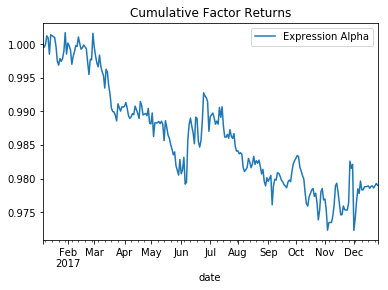

In [12]:
make_factor_plot(df, start_date, end_date);

In [15]:
e = ExpressionAlpha('rank(log(close/delay(opens, 5)))').parse().transform().generate_pipeline_code()

In [16]:
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume]
    window_length = 7

    def compute(self, today, assets, out, returns, opens, high, low, close, volume):
        v34 = np.roll(opens, 5)
        v35 = close / v34
        v36 = np.log(v35)
        v37 = np.apply_along_axis(rankdata, 1, v36)
        out[:] = v37[-1]



In [17]:
a

array([[ 0.77132064,  0.02075195],
       [ 0.63364823,  0.74880388],
       [ 0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071],
       [ 0.16911084,  0.08833981],
       [ 0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226],
       [ 0.81262096,  0.61252607],
       [ 0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578]])

In [18]:
b

array([[ 0.54254437,  0.14217005],
       [ 0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399],
       [ 0.61776698,  0.51313824],
       [ 0.65039718,  0.60103895],
       [ 0.8052232 ,  0.52164715],
       [ 0.90864888,  0.31923609],
       [ 0.09045935,  0.30070006],
       [ 0.11398436,  0.82868133],
       [ 0.04689632,  0.62628715]])

In [86]:


def column_corr((a, b), window=-1):
    if window==-1:
        window = a.shape[0]
    out = np.zeros(shape = (1, a.shape[1]))
    for i in xrange(a.shape[1]-1):
        out[i] = pearsonr(a[-window:, i], b[-window:, i])[0]
    return out
        

In [22]:
import numpy as np
from scipy.stats import pearsonr
np.random.seed(10)
a = np.random.random(30).reshape(10,3)
b = np.random.random(30).reshape(10,3)

In [191]:
def roll_corr((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

In [192]:
roll_corr((a,b), window=5)

0 --> 4
1 --> 5
2 --> 6
3 --> 7
4 --> 8
5 --> 9


array([[        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [ 0.28810753,  0.27836622,  0.88397851],
       [-0.04076151,  0.45254981,  0.83259104],
       [ 0.62262963, -0.4188768 ,  0.35479134],
       [ 0.13130652, -0.91441413, -0.21713372],
       [ 0.54327228, -0.91390053, -0.84033286],
       [ 0.45268257, -0.95245888, -0.50107515]])

In [207]:
def scale(x):
    return (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x)))

In [211]:
np.apply_along_axis(lambda x: (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x))), 1, a)

array([[ 0.32572934, -0.5       ,  0.17427066],
       [ 0.4853247 ,  0.0146753 , -0.5       ],
       [-0.23118186,  0.5       , -0.26881814],
       [-0.5       ,  0.11250682,  0.38749318],
       [-0.5       ,  0.07890222,  0.42109778],
       [ 0.14084777,  0.35915223, -0.5       ],
       [ 0.5       , -0.02694105, -0.47305895],
       [-0.45819778, -0.04180222,  0.5       ],
       [-0.23369585, -0.26630415,  0.5       ],
       [-0.5       ,  0.41441077,  0.08558923]])

array([[ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895]])

In [33]:
from __future__ import division

np.sum()

1.0

55